In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from pandas.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/public_timeseries_testing_util.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test

In [2]:
train_proteins_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv')
print(train_proteins_df.shape)
print(train_proteins_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
train_proteins_df.head(10)

(232741, 5)
33.64677047729492  MBs


,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.30
1,55_0,0,55,O00533,732430.00
2,55_0,0,55,O00584,39585.80
3,55_0,0,55,O14498,41526.90
4,55_0,0,55,O14773,31238.00
5,55_0,0,55,O14791,4202.71
6,55_0,0,55,O15240,177775.00
7,55_0,0,55,O15394,62898.20
8,55_0,0,55,O43505,333376.00
9,55_0,0,55,O60888,166850.00


In [3]:
train_peptides_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv')
print(train_peptides_df.shape)
print(train_peptides_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
train_peptides_df.head(10)

(981834, 6)
212.76564979553223  MBs


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7
5,55_0,0,55,O00533,TLKIENVSYQDKGNYR,23216.5
6,55_0,0,55,O00533,VIAVNEVGR,170878.0
7,55_0,0,55,O00533,VMTPAVYAPYDVK,148771.0
8,55_0,0,55,O00533,VNGSPVDNHPFAGDVVFPR,55202.1
9,55_0,0,55,O00584,ELDLNSVLLK,27229.3


In [4]:
pro_pep_join = pd.merge(train_proteins_df, train_peptides_df, on=['patient_id','visit_id','visit_month','UniProt'], how='inner')

del train_proteins_df, train_peptides_df
gc.collect()

42

In [5]:
train_clinical_data_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
print(train_clinical_data_df.shape)
print(train_clinical_data_df.memory_usage(deep=True).sum()/1024/1024, " MBs")

full_training_data = pd.merge(pro_pep_join, train_clinical_data_df, on=['patient_id','visit_id','visit_month'], how='inner')

del pro_pep_join, train_clinical_data_df
gc.collect()

print(full_training_data.shape)
full_training_data.head(10)

(2615, 8)
0.3944511413574219  MBs
(941744, 12)


,visit_id,visit_month,patient_id,UniProt,NPX,Peptide,PeptideAbundance,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,0,55,O00391,11254.3,NEQEQPLGQWHLS,11254.3,10.0,6.0,15.0,NaN,NaN
1,55_0,0,55,O00533,732430.0,GNPEPTFSWTK,102060.0,10.0,6.0,15.0,NaN,NaN
2,55_0,0,55,O00533,732430.0,IEIPSSVQQVPTIIK,174185.0,10.0,6.0,15.0,NaN,NaN
3,55_0,0,55,O00533,732430.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,10.0,6.0,15.0,NaN,NaN
4,55_0,0,55,O00533,732430.0,SMEQNGPGLEYR,30838.7,10.0,6.0,15.0,NaN,NaN
5,55_0,0,55,O00533,732430.0,TLKIENVSYQDKGNYR,23216.5,10.0,6.0,15.0,NaN,NaN
6,55_0,0,55,O00533,732430.0,VIAVNEVGR,170878.0,10.0,6.0,15.0,NaN,NaN
7,55_0,0,55,O00533,732430.0,VMTPAVYAPYDVK,148771.0,10.0,6.0,15.0,NaN,NaN
8,55_0,0,55,O00533,732430.0,VNGSPVDNHPFAGDVVFPR,55202.1,10.0,6.0,15.0,NaN,NaN
9,55_0,0,55,O00584,39585.8,ELDLNSVLLK,27229.3,10.0,6.0,15.0,NaN,NaN


In [6]:
full_training_data = full_training_data.drop(columns=['UniProt','Peptide','upd23b_clinical_state_on_medication'])
full_training_data.head(10)

,visit_id,visit_month,patient_id,NPX,PeptideAbundance,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,0,55,11254.3,11254.3,10.0,6.0,15.0,NaN
1,55_0,0,55,732430.0,102060.0,10.0,6.0,15.0,NaN
2,55_0,0,55,732430.0,174185.0,10.0,6.0,15.0,NaN
3,55_0,0,55,732430.0,27278.9,10.0,6.0,15.0,NaN
4,55_0,0,55,732430.0,30838.7,10.0,6.0,15.0,NaN
5,55_0,0,55,732430.0,23216.5,10.0,6.0,15.0,NaN
6,55_0,0,55,732430.0,170878.0,10.0,6.0,15.0,NaN
7,55_0,0,55,732430.0,148771.0,10.0,6.0,15.0,NaN
8,55_0,0,55,732430.0,55202.1,10.0,6.0,15.0,NaN
9,55_0,0,55,39585.8,27229.3,10.0,6.0,15.0,NaN


In [7]:
full_training_data_melted = full_training_data.melt(id_vars=['visit_id','visit_month','patient_id','NPX','PeptideAbundance'], value_vars=['updrs_1','updrs_2','updrs_3','updrs_4'],
        var_name='updrs_test', value_name='updrs_test_score')

full_training_data_melted['group_key'] = full_training_data_melted['visit_month']
full_training_data_melted['row_id'] = full_training_data_melted['visit_id'] + '_' + full_training_data_melted['updrs_test']

full_training_data_melted[full_training_data_melted['visit_id']=='55_0']

,visit_id,visit_month,patient_id,NPX,PeptideAbundance,updrs_test,updrs_test_score,group_key,row_id
0,55_0,0,55,11254.3,11254.3,updrs_1,10.0,0,55_0_updrs_1
1,55_0,0,55,732430.0,102060.0,updrs_1,10.0,0,55_0_updrs_1
2,55_0,0,55,732430.0,174185.0,updrs_1,10.0,0,55_0_updrs_1
3,55_0,0,55,732430.0,27278.9,updrs_1,10.0,0,55_0_updrs_1
4,55_0,0,55,732430.0,30838.7,updrs_1,10.0,0,55_0_updrs_1
...,...,...,...,...,...,...,...,...,...
2826158,55_0,0,55,408698.0,98654.3,updrs_4,NaN,0,55_0_updrs_4
2826159,55_0,0,55,408698.0,218723.0,updrs_4,NaN,0,55_0_updrs_4
2826160,55_0,0,55,29758.8,29758.8,updrs_4,NaN,0,55_0_updrs_4
2826161,55_0,0,55,23833.7,23833.7,updrs_4,NaN,0,55_0_updrs_4


In [8]:
"""print(full_training_data_melted.group_key.nunique())
print(full_training_data_melted.shape)"""
## 15, (3766976, 9)
full_training_data_melted.updrs_test_score.unique()

array([10., 11.,  2.,  1.,  8.,  6.,  9., 12.,  5.,  7.,  4., 17.,  3.,
        0., 14., 16., 15., 20., 18., 13., 33., 28., 25., 26., 19., 21.,
       24., 22., 23., 27., 29., 36., 38., 30., 46., 41., 40., 39., 47.,
       32., 31., 34., 56., 52., 35., nan, 51., 44., 68., 43., 67., 61.,
       45., 59., 37., 48., 42., 60., 55., 49., 63., 78., 58., 50., 66.])

In [9]:
full_training_data_melted.isna().sum()

visit_id                 0
visit_month              0
patient_id               0
NPX                      0
PeptideAbundance         0
updrs_test               0
updrs_test_score    455334
group_key                0
row_id                   0
dtype: int64

In [10]:
full_training_data_melted['nan_record_count_per_test'] = \
full_training_data_melted.updrs_test_score.isnull().groupby([full_training_data_melted['updrs_test']]).transform('sum').astype(int)

In [11]:
print(full_training_data_melted[full_training_data_melted['updrs_test']=='updrs_4'].nan_record_count_per_test.unique())
print(full_training_data_melted[full_training_data_melted['updrs_test']=='updrs_3'].nan_record_count_per_test.unique())
print(full_training_data_melted[full_training_data_melted['updrs_test']=='updrs_2'].nan_record_count_per_test.unique())
print(full_training_data_melted[full_training_data_melted['updrs_test']=='updrs_1'].nan_record_count_per_test.unique())

[446214]
[9120]
[0]
[0]


In [12]:
full_training_data_melted.groupby(['updrs_test']).agg(visit_month_per_patient=('visit_id', 'count') ).reset_index(level=['updrs_test'])

,updrs_test,visit_month_per_patient
0,updrs_1,941744
1,updrs_2,941744
2,updrs_3,941744
3,updrs_4,941744


In [13]:
full_training_data_melted[['updrs_test_score','PeptideAbundance','NPX']].corr()

,updrs_test_score,PeptideAbundance,NPX
updrs_test_score,1.000000,-0.000654,-0.001069
PeptideAbundance,-0.000654,1.000000,0.506847
NPX,-0.001069,0.506847,1.000000


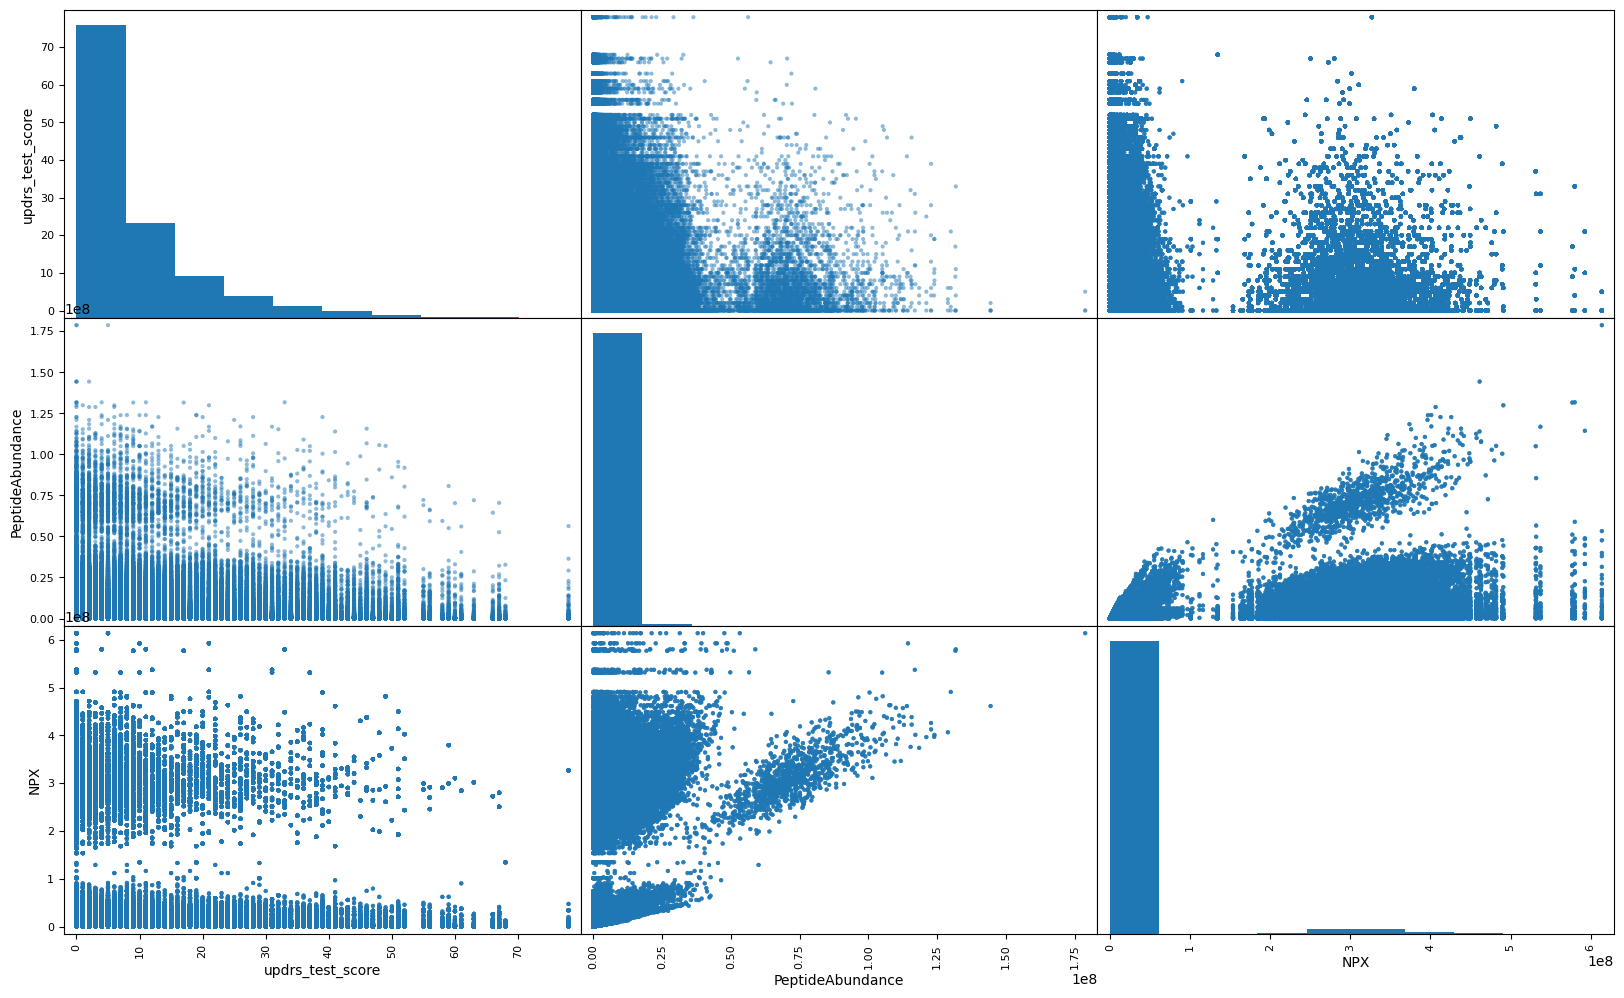

In [14]:
attributes = ['updrs_test_score', 'PeptideAbundance', 'NPX']

scatter_plot_arr = scatter_matrix(full_training_data_melted[attributes], figsize=(20,12))

<AxesSubplot:xlabel='NPX', ylabel='PeptideAbundance'>

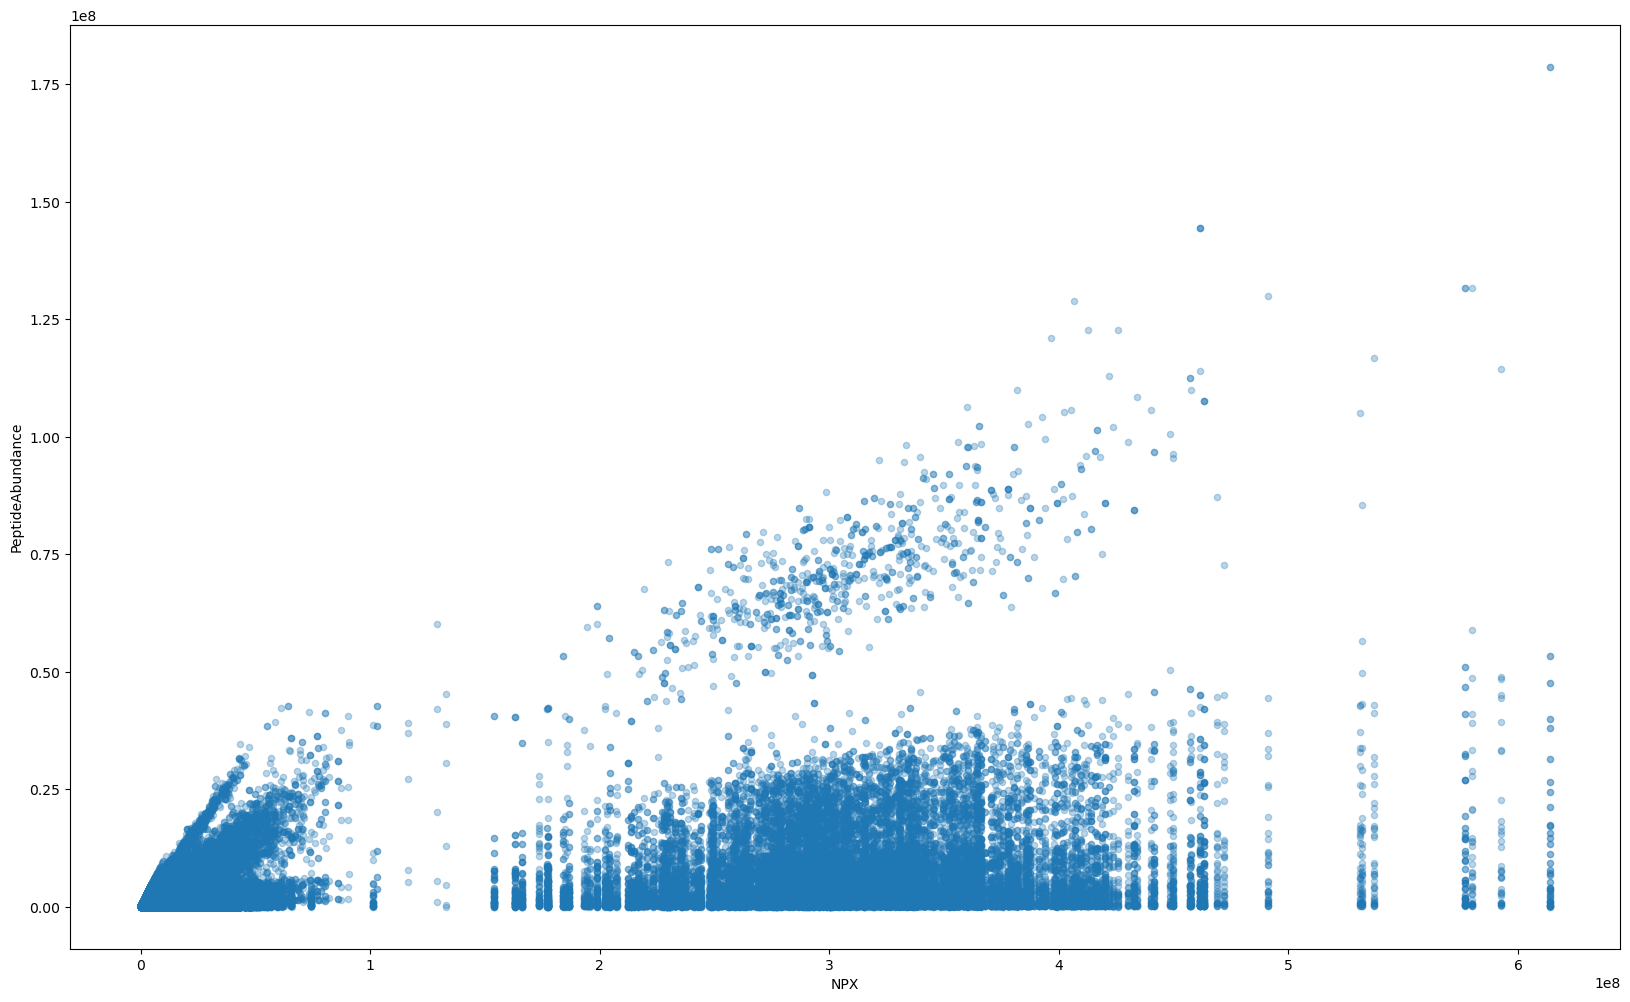

In [15]:
full_training_data_melted[full_training_data_melted['updrs_test_score']==0].plot(kind="scatter", x="NPX", y="PeptideAbundance", alpha=0.3, figsize=(20,12))